In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from IPython.display import clear_output

from Alpha import Alpha

In [ ]:
# FILTER TICKERS

close_df = pd.read_parquet("binance/close.parquet")

start_date = "2022-06-01"
end_date = "2022-09-30"
close_df = close_df.loc[start_date:end_date]

close_df = close_df.dropna(how='all', axis=1)
close_df = close_df.ffill(limit=5)

number_of_nan = close_df.isna().sum(axis=0)
nan_mask = number_of_nan == 0
close_df = close_df.loc[:, nan_mask]

filtered_tickers = close_df.columns
pd.Series(filtered_tickers).to_csv("filtered_tickers.csv")
close_df.shape

In [5]:
# DATE PERIOD

start_date = "2022-06-01"
end_date = "2022-09-30"

# READ DATA

all_files = os.listdir("binance/")

bar = ["close", "open", "high", "low", "vwap"]
for bar_component in bar:
    all_files.remove(f"{bar_component}.parquet")

dataset = pd.concat({
    filename.split('.')[0]: pd.read_parquet(f"binance/{filename}").loc[start_date:end_date, filtered_tickers].ffill().stack()
    for filename in tqdm(all_files)}, 
    axis=1)

100%|██████████| 70/70 [00:13<00:00,  5.26it/s]


In [9]:
# MAKE STATIONARY DATASET

stationary_dataset = pd.DataFrame()

# WORKING WITH PRICE DATA
bar.remove("vwap")
for bar_component in bar: 
    stationary_dataset[bar_component + "_pct"] = (
        pd.read_parquet(f"binance/{bar_component}.parquet")[filtered_tickers]
        .ffill()
        .pct_change(fill_method=None)
        .loc[start_date:end_date]
        .stack())

# WORKING WITH ORDER BOOK DATA

stationary_dataset["volume"] = dataset["sell_volume"] / dataset["buy_volume"]
stationary_dataset["count"] = dataset["sell_count"] / dataset["buy_count"]

stationary_dataset["best_bid_ask"] = dataset["best_bid"] / dataset["best_ask"]
stationary_dataset["best_bid_ask_size"] = dataset["best_bid_size"] / dataset["best_ask_size"]
stationary_dataset["high_bid_low_ask"] = dataset["bid_high"] / dataset["ask_low"]
stationary_dataset["low_bid_high_ask"] = dataset["bid_low"] / dataset["ask_high"]


for column_name in dataset.columns:

    # WORKING WITH MARKET ORDER DATA

    if "mo" in column_name:
        if "hh" in column_name: 
            stationary_dataset[f"mo_{column_name[4:]}"] = dataset[column_name]
        elif "1" in column_name:
            suffix = column_name.split("1")[1]
            stationary_dataset[f"mo_{column_name[4:]}"] = dataset[f"mo1{suffix}"] / (dataset[f"mo0{suffix}"] + 1)
        

    # WORKING WITH QUANTILE DATA

    elif column_name.startswith("bid") and column_name.endswith("size"):
        quantile = column_name.split('_')[1]
        stationary_dataset[f"quantile_{quantile}_size"] = dataset[f"bid_{quantile}_size"] / (dataset[f"ask_{quantile}_size"] + 1)
    elif column_name.startswith("bid") and column_name.endswith("vwap"):
        quantile = column_name.split('_')[1]
        stationary_dataset[f"quantile_{quantile}_vwap"] = dataset[f"bid_{quantile}_vwap"] / (dataset[f"ask_{quantile}_vwap"] + 1)


stationary_dataset = stationary_dataset.sort_index(axis=1)

# ADD TARGET TO DATASET
stationary_dataset["target"] = (
    pd.read_parquet(f"binance/vwap.parquet")[filtered_tickers]
    .pct_change(fill_method=None)
    .shift(-1)
    .loc[start_date:end_date]
    .ffill()
    .stack())

# SAVE DATASET
stationary_dataset.to_parquet("stationary_dataset.gzip", compression='gzip')

stationary_dataset

best_bid_ask  best_bid_ask_size  close_pct  \
2022-06-01 00:00:00 1INCH-USDT      0.998969           0.817322  -0.002060   
                    AAVE-USDT       0.999115           0.112609  -0.015693   
                    ACA-USDT        0.997613           1.598995  -0.004751   
                    ACH-USDT        0.998269           1.097812  -0.002877   
                    ACM-USDT        0.999699           0.004426  -0.003303   
...                                      ...                ...        ...   
2022-09-30 23:30:00 YGG-USDT        0.999132           5.777978   0.002612   
                    ZEC-USDT        0.998217           0.096064   0.001789   
                    ZEN-USDT        0.999292           0.587511   0.003554   
                    ZIL-USDT        0.999680           1.642344   0.002462   
                    ZRX-USDT        0.999626           0.232589   0.004513   

                                   count  high_bid_low_ask  high_pct  \
2022-06-01 00:00:00 1INCH-USDT  1.851852          1.005171 -0.001028   
                    AAVE-USDT   0.772973          1.020408  0.000870   
                    ACA-USDT    0.800000          1.019231 -0.002353   
                    ACH-USDT    0.487805          1.008102  0.001149   
                    ACM-USDT    1.285714          1.006327 -0.016490   
...                                  ...               ...       ...   
2022-09-30 23:30:00 YGG-USDT    0.437500          1.005826  0.003192   
                    ZEC-USDT    1.028571          1.005376  0.001786   
                    ZEN-USDT    0.954545          1.005104  0.003554   
                    ZIL-USDT    0.720588          1.004399  0.002462   
                    ZRX-USDT    0.703704          1.006403  0.003380   

                                low_bid_high_ask   low_pct  mo_buy_count  \
2022-06-01 00:00:00 1INCH-USDT          0.995885 -0.003093      1.595238   
                    AAVE-USDT           0.980000 -0.009666      0.545833   
                    ACA-USDT            0.985816 -0.009524      0.291667   
                    ACH-USDT            0.992533  0.000000      0.312500   
                    ACM-USDT            0.994306  0.000301      0.153846   
...                                          ...       ...           ...   
2022-09-30 23:30:00 YGG-USDT            0.995081  0.001450      0.133333   
                    ZEC-USDT            0.998214  0.001795      0.333333   
                    ZEN-USDT            0.995748  0.002734      0.352941   
                    ZIL-USDT            0.996792  0.003878      0.682927   
                    ZRX-USDT            0.993638  0.000377      0.333333   

                                mo_buy_hh  ...  quantile_1_size  \
2022-06-01 00:00:00 1INCH-USDT   0.073072  ...         3.358685   
                    AAVE-USDT    0.028236  ...         1.683440   
                    ACA-USDT     0.308406  ...         0.952502   
                    ACH-USDT     0.116865  ...         1.028650   
                    ACM-USDT     0.383247  ...         3.207335   
...                                   ...  ...              ...   
2022-09-30 23:30:00 YGG-USDT     0.490566  ...         2.227916   
                    ZEC-USDT     0.060035  ...         1.077083   
                    ZEN-USDT     0.110594  ...         1.675742   
                    ZIL-USDT     0.047881  ...         1.091101   
                    ZRX-USDT     0.076998  ...         1.404640   

                                quantile_1_vwap  quantile_25_size  \
2022-06-01 00:00:00 1INCH-USDT         0.489076          2.014890   
                    AAVE-USDT          0.980874          1.223648   
                    ACA-USDT           0.292710          1.965553   
                    ACH-USDT           0.016926          1.327065   
                    ACM-USDT           0.761151          0.680027   
...                                         ...               ...   
2022-09-30 23:30:00 YGG-USDT 

LSTM NEURAL NETWORK

In [13]:
stationary_dataset = pd.read_parquet("stationary_dataset.gzip")
idx = pd.IndexSlice

params = dict(
    input_dim = stationary_dataset.shape[1]-1,
    hidden_dim = (stationary_dataset.shape[1]-1) // 4,
    output_dim = 1,
    batch_size = 10,
    learning_rate = 1e-3,
    epochs = 5,
    train_test_split = stationary_dataset.loc[idx[:"2022-06-15", :], :].shape[0]
)

In [120]:
def cut_outliers(x, show=False):

    if show:
        # данные до обработки
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
        ax1.set_title('before formatting')
        ax1.plot(x)

    if cut_outliers:
        lower_bound = np.quantile(x, 0.005)
        upper_bound = np.quantile(x, 0.995)
        x[x < lower_bound] = lower_bound
        x[x > upper_bound] = upper_bound

    if show:
        # данные после обработки
        ax2.set_title('after formatting')
        ax2.plot(x)
        plt.show()

    return x

for column_name in stationary_dataset.columns:
    stationary_dataset[column_name] = cut_outliers(stationary_dataset[column_name].values)

In [11]:
# MODEL DATA STRUCTURE

class lstm_dataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data[:, :-1], dtype=torch.float32)
        self.label = torch.tensor(data[:, -1], dtype=torch.float32).unsqueeze_(1)
        self.n_samples = data.shape[0] 

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
# LSTM NEURAL NETWORK

class LSTM_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTM_Model, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

In [ ]:
# TRAINING & PREDICTION

train_dataset = lstm_dataset(stationary_dataset.loc[idx[:"2022-08-20", :], :].values)
valid_dataset = lstm_dataset(stationary_dataset.loc[idx["2022-08-21":"2022-08-31", :], :].values)
test_dataset = lstm_dataset(stationary_dataset.loc[idx["2022-09-01":, :], :].values)

train_loader = DataLoader(train_dataset, batch_size=64)
valid_loader = DataLoader(valid_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

lstm_model = LSTM_Model(params['input_dim'], params['hidden_dim'], params['output_dim'])
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=params['learning_rate'])

train_losses = []
valid_losses = []

for i in tqdm(range(params['epochs'])):

    # TRAIN

    lstm_model.train()
    train_loss = 0
    for X_train, y_train in train_loader:
        
        optimizer.zero_grad()
        y_pred_train = lstm_model(X_train)
        loss = criterion(y_pred_train, y_train)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

    # VALIDATION

    lstm_model.eval()
    valid_loss = 0

    for X_valid, y_valid in valid_loader:
        y_pred_valid = lstm_model(X_valid)
        loss = criterion(y_pred_valid, y_valid)
        valid_loss += loss.item()

    valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(valid_loss)   
    

    clear_output(wait=True)
    fig, axs = plt.subplots(2, 1, layout='constrained')
    axs[0].plot(np.arange(1, i+2), train_losses, 'tab:blue')
    axs[0].set_ylabel('train_loss')

    axs[1].plot(np.arange(1, i+2), valid_losses, 'tab:orange')
    axs[1].set_xlabel('epoches')
    axs[1].set_ylabel('valid_loss')
    plt.show()

# TEST

predicted_return = []
with torch.no_grad():
    test_loss = 0
    for X_test, y_test in test_loader:
        y_pred_test = lstm_model(X_test)
        predicted_return.extend(y_pred_test.detach().numpy().flatten())
        loss = criterion(y_pred_test, y_test)
        test_loss += loss.item()
test_loss = test_loss / len(test_loader)
print("Test Loss: ", test_loss)


In [ ]:
LSTM_WEIGHTS = pd.Series(np.array(predicted_return).flatten(), index=stationary_dataset.loc[idx["2022-09-01":, :], :].index)

LSTM_WEIGHTS = LSTM_WEIGHTS.reset_index()
LSTM_WEIGHTS = - LSTM_WEIGHTS.pivot(index="level_0", columns="level_1", values = 0)

LSTM_WEIGHTS.to_parquet("raw_alpha_weights/LSTM_WEIGHTS.gzip", compression='gzip')

Стратегия LSTM

Annualized Sharpe Ratio = 11.84
Daily tvr = 488.19%
Annual return = 63.62%
Max Drawdown = -0.9%
Margin = 0.0 bp



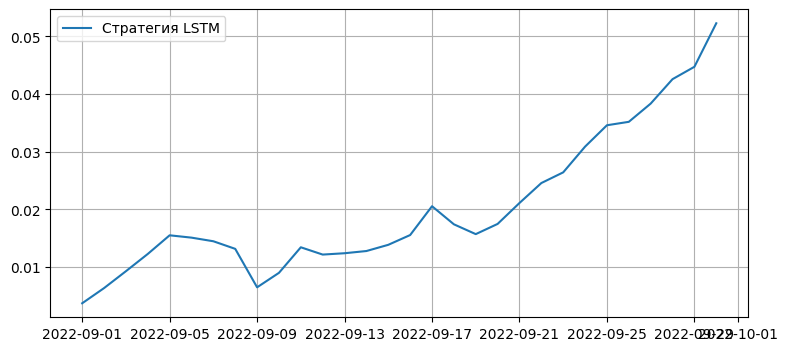

In [3]:
LSTM_WEIGHTS = pd.read_parquet("raw_alpha_weights/LSTM_WEIGHTS.gzip")
close_df = pd.read_parquet("binance/close.parquet")
vwap_df = pd.read_parquet("binance/vwap.parquet")

start_date = "2022-09-01"
end_date = "2022-09-30"

LSTM_STRATEGY = Alpha(LSTM_WEIGHTS, close_df, vwap_df)
LSTM_STRATEGY.filter_tickers(filtered_tickers)
LSTM_STRATEGY.filter_date((start_date, end_date))
LSTM_STRATEGY.truncate_and_normalize(0.05)
LSTM_STRATEGY.decay(9)


plt.figure(figsize=(9, 4))
LSTM_STRATEGY.backtest(delay=1, display=True, label="Стратегия LSTM")
plt.legend()
plt.grid()
plt.show()